# Cleaning Movie Review Data

In this notebook, we will apply pre processing techniques to clean the data obtained from : [movie review data](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) and make it ready to use for training various models 

In [1]:
import pandas as pd 
import re
import string
import numpy as np
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf7
from spellchecker import SpellChecker
from multiprocessing import Pool, cpu_count
from textblob import TextBlob
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from symspellpy import SymSpell, Verbosity
import emoji

In [12]:
half1 = pd.read_csv('../data/raw/Imdb_part1.csv')
half2 = pd.read_csv('../data/raw/Imdb_part2.csv')
imdb_data = pd.concat([half1, half2], ignore_index=True)

In [13]:
imdb_data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Lets first check if there are any missing values in the dataset :

In [3]:
imdb_data.isna().sum()

review       0
sentiment    0
dtype: int64

We will now focus on the review column and see what pre processing steps need to be applied

In [4]:
imdb_data['review'].describe()

count                                                 50000
unique                                                49582
top       Loved today's show!!! It was a variety and not...
freq                                                      5
Name: review, dtype: object

In [5]:
imdb_data['review'].str.len().describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review, dtype: float64

Lets start with converting the text to lowercase, removing special symbols, punctuations, html tags (for eg : **<\/br>**) and URLs as :

- **Converting to lowercase** : helps to reduce the dimensionality of the feature space and makes the model more robust to case variations

- **Removing special symbols/punctuations** : These characters don't add much value to the sentiment analysis task and can be considered as noise. Removing them can help to improve the model's performance.

- **Removing HTML tags** : HTML tags are also irrelevant to predicting sentiment and can be deemed as noise.



In [6]:
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub(r'\s+', ' ', text).strip() 
    return text

In [7]:
imdb_data['review'] = imdb_data['review'].apply(clean_text)
imdb_data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


Handling ChatWords, also known as internet slang or informal language used in online communication, is important in text preprocessing to ensure accurate analysis and understanding of text data. By converting ChatWords into their standard English equivalents or formal language equivalents, models can effectively interpret the meaning of the text


Lets look at how many reviews have chatwords and convert them to standard english :

In [8]:
# reference for list of chat words : https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
chat_word = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': "For What It's Worth",
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you (also a chat program)',
    'ILU': 'ILU: I Love You',
    'IMHO': 'In My Honest/Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My A.. Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'PITA': 'Pain In The A..',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My A.. Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The F...',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait...',
    '7K': 'Sick:-D Laugher',
    'TFW': 'That feeling when',
    'MFW': 'My face when',
    'MRW': 'My reaction when',
    'IFYP': 'I feel your pain',
    'TNTL': 'Trying not to laugh',
    'JK': 'Just kidding',
    'IDC': "I don't care",
    'ILY': 'I love you',
    'IMU': 'I miss you',
    'ADIH': 'Another day in hell',
    'ZZZ': 'Sleeping, bored, tired',
    'WYWH': 'Wish you were here',
    'TIME': 'Tears in my eyes',
    'BAE': 'Before anyone else',
    'FIMH': 'Forever in my heart',
    'BSAAW': 'Big smile and a wink',
    'BWL': 'Bursting with laughter',
    'BFF': 'Best friends forever',
    'CSL': "Can't stop laughing"
}

chat_word = {k.lower(): v.lower() for k, v in chat_word.items()}

In [9]:
# Function to check if a review contains any chat words
def contains_chat_words(text, chat_word_dict):
    words = set(text.lower().split())  # Convert to lowercase and split into words
    return any(word in chat_word_dict for word in words)

num_reviews_with_chat_words = sum(imdb_data["review"].apply(lambda x: contains_chat_words(x, chat_word)))
print(f"Number of reviews with chat words: {num_reviews_with_chat_words}")

Number of reviews with chat words: 17165


In [10]:
def replace_chat_words(text, chat_word_dict):
    
    words = text.split()
    words = [chat_word_dict.get(word.lower(), word) for word in words]
    return " ".join(words)

imdb_data["review"] = imdb_data["review"].apply(lambda x: replace_chat_words(x, chat_word))

In [11]:
num_reviews_with_chat_words = sum(imdb_data["review"].apply(lambda x: contains_chat_words(x, chat_word)))
print(f"Number of reviews with chat words: {num_reviews_with_chat_words}")

Number of reviews with chat words: 0


Some reviews might also include other characters such as emojis which might negatively impact the model. Lets check for emojis and remove them from their respective review :

In [12]:
def has_emojis(text):
    emojis = [char for char in text if emoji.is_emoji(char)]
    return emojis

has_emojis_series = imdb_data["review"].apply(has_emojis)

for i, emojis in enumerate(has_emojis_series):
    if emojis:
        print(f"Review Number: {i+1} - Emojis: {emojis}")

print(f"Total number of reviews with emojis: {sum(1 for emojis in has_emojis_series if emojis)}")

Review Number: 13736 - Emojis: ['®']
Review Number: 21142 - Emojis: ['®']
Review Number: 22729 - Emojis: ['®']
Review Number: 36508 - Emojis: ['©']
Review Number: 46516 - Emojis: ['®']
Total number of reviews with emojis: 5


In [13]:
def remove_emojis(text):
    return ''.join([char for char in text if not emoji.is_emoji(char)])

imdb_data["review"] = imdb_data["review"].apply(remove_emojis)

In [14]:
imdb_data

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend te...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the tears in my eyes of...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,im going to have to disagree with the previous...,negative


Another crucial pre processing step would be to tokenise the text (breaking down the text into individual words or tokens) and then removing common words like **the** , **and** etc. that don't add much value to the analysis

We will now apply this to the dataset :

In [15]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
# Load English stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to c:\Users\dusad\AppData\Lo
[nltk_data]     cal\Programs\Python\Python312\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to c:\Users\dusad\AppData\Local\
[nltk_data]     Programs\Python\Python312\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to c:\Users\dusad\AppData\Lo
[nltk_data]     cal\Programs\Python\Python312\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [16]:
# Function to remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)  # Tokenize text
    filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(filtered_words)

In [17]:
imdb_data['review'] = imdb_data['review'].apply(remove_stopwords)

In [18]:
# Check if any review contains stop words
contains_stop_words = imdb_data['review'].apply(lambda x: any(word in stop_words for word in x.split()))
contains_stop_words.sum()

0

A couple more common text pre processing techniques are :

- **Stemming or Lemmatization** : 

    -   Reduces words to their base form, for eg :  words like "running", "runs", and "runner" are all reduced to "run"

    -   This helps to reduce the dimensionality of the feature space and allows the model to focus on the underlying meaning of the words rather than their specific forms.

    -  It also helps to reduce the impact of noise and variability in the text data.

-   **Padding & Truncation** :

    -  Standardizes the length of the input sequences, so that all sequences have the same length. 

    -  This is necessary because deep learning models require input data to be in a fixed-size format which in turn helps the model to learn more effectively and prevents it from being biased towards longer or shorter sequences.

In [19]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to c:\Users\dusad\AppData\Loca
[nltk_data]     l\Programs\Python\Python312\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to c:\Users\dusad\AppData\Loca
[nltk_data]     l\Programs\Python\Python312\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [20]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)  # Tokenize text
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize each word
    return ' '.join(lemmatized_words)  # Reconstruct sentence

In [21]:
# Apply lemmatization to reviews
imdb_data['review'] = imdb_data['review'].apply(lemmatize_text)

Before we apply padding lets quickly look at the distribution of the length of reviews (word count) to determine what size we should cap our sequences/reviews :

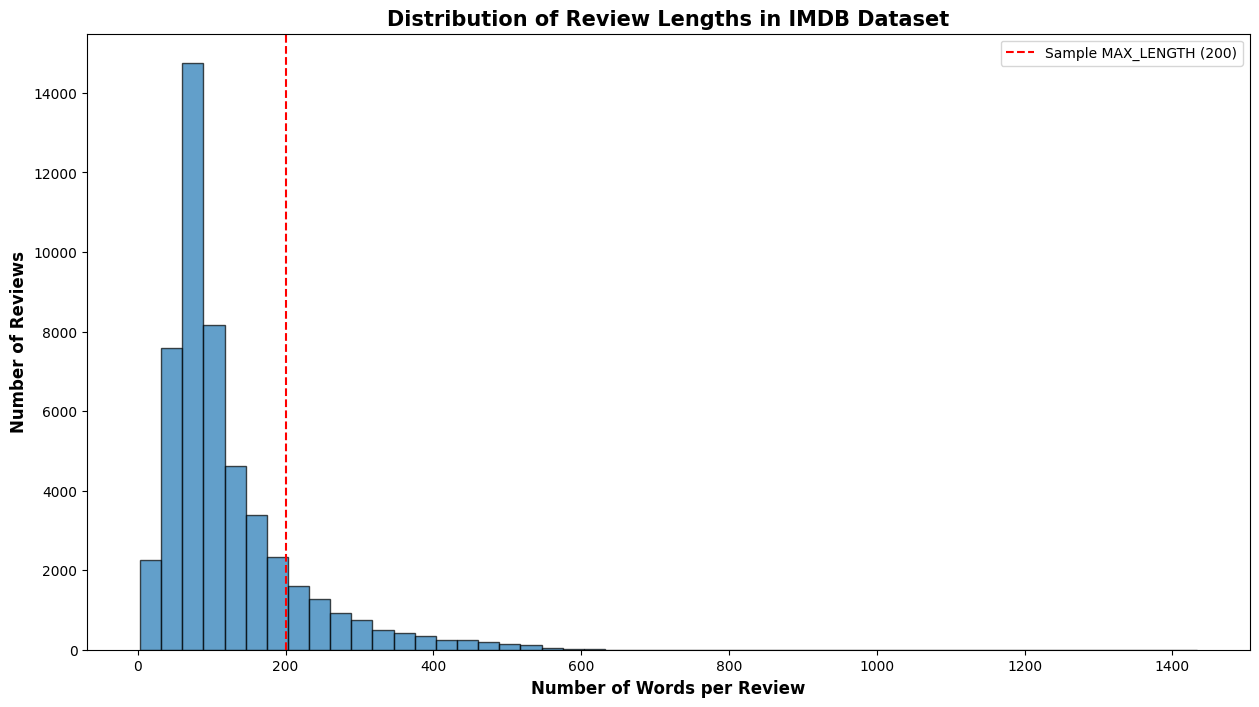

In [22]:
review_lengths = [len(word_tokenize(text)) for text in imdb_data['review']]

# Plot the distribution of review lengths
plt.figure(figsize=(15, 8))
plt.hist(review_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(x=200, color='red', linestyle='dashed', label='Sample MAX_LENGTH (200)')
plt.xlabel('Number of Words per Review', fontsize=12, fontweight='bold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='bold')
plt.title('Distribution of Review Lengths in IMDB Dataset', fontsize=15, fontweight='bold')
plt.legend()
plt.show()

In [23]:
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]
labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-1000', '1000+']
review_length_bins = pd.cut(review_lengths, bins=bins, labels=labels)
review_length_bins.value_counts()

0-100       28560
100-200     14360
200-300      4340
300-400      1664
400-500       775
500-1000      297
1000+           4
Name: count, dtype: int64

From the above, we can see most reviews have a word count of < 400, so an appropriate **MAX_LENGTH** value to set would be 300

In [24]:
# Tokenization for Deep Learning
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>") 
tokenizer.fit_on_texts(imdb_data['review'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(imdb_data['review'])

# Padding & Truncation to ensure fixed-length input sequences
MAX_LENGTH = 300  # Define max length for truncation/padding
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

imdb_data['padded_sequences'] = list(padded_sequences)

In [25]:
imdb_data

,review,sentiment,padded_sequences
0,one reviewer mentioned watching 1 oz episode y...,positive,"[4, 1023, 946, 68, 417, 3107, 178, 369, 2916, ..."
1,wonderful little production filming technique ...,positive,"[293, 47, 241, 1236, 1611, 15988, 1, 1357, 61,..."
2,thought wonderful way spend tear eye hot summe...,positive,"[97, 293, 26, 994, 12, 8, 788, 1304, 2215, 107..."
3,basically there family little boy jake think t...,negative,"[584, 134, 125, 47, 207, 3362, 31, 134, 525, 3..."
4,petter matteis love tear eye money visually st...,positive,"[1, 1, 36, 12, 8, 200, 1977, 1252, 3, 35, 284,..."
...,...,...,...
49995,thought movie right good job wasnt creative or...,positive,"[97, 2, 107, 6, 182, 192, 1348, 120, 25, 867, ..."
49996,bad plot bad dialogue bad acting idiotic direc...,negative,"[22, 41, 22, 286, 22, 45, 2748, 850, 531, 1425..."
49997,catholic taught parochial elementary school nu...,negative,"[2958, 3919, 1, 7505, 266, 4122, 3919, 1, 1597..."
49998,im going disagree previous comment side maltin...,negative,"[66, 79, 2760, 777, 345, 352, 10353, 4, 208, 8..."


In [26]:
oov_count = sum(1 for seq in sequences for word in seq if word == tokenizer.word_index.get("<OOV>", 0))
total_words = sum(len(seq) for seq in sequences)
oov_percentage = (oov_count / total_words) * 100 if total_words > 0 else 0

print(f"Total words in dataset: {total_words}")
print(f"Out-of-Vocabulary (OOV) words: {oov_count}")
print(f"Percentage of OOV words: {oov_percentage:.2f}%")

Total words in dataset: 6016170
Out-of-Vocabulary (OOV) words: 392373
Percentage of OOV words: 6.52%


When we use a **tokenizer**, it basically creates a vocabulary by assigning each unique word in the dataset a number (index). However, not all words are useful, some are rare and might appear only once or twice in the entire dataset.

Therefore, we have limited the vocabulary to 20,000 words meaning only the 20,000 most common words in the dataset will be given a number. Any word beyond this limit will be replaced with **\<OOV>** (out-of-vocabulary token).

The % of **OOV** words is 6.55, which is quite reasonable as the typical range is between 5-10%

In hindsight, looking at the distribution of word counts for reviews might not have been as useful as we thought initially (setting **MAX_LENGTH** to 300) as we're tokenising only the 20,000 most common words and padding/truncating the sequences to a fixed length (which is also 300). However, it's still a good observation to have. 

Lets now save the cleaned dataset and train a few models which will then tell us if any more pre processing is required (refer to **modelling** notebook) :

In [27]:
imdb_data.to_csv('../data/clean/cleaned_imdb_data.csv', index=False)